In [ ]:
!pip install transformers datasets flask tensorflow -q

import pandas as pd
import random
import re
import nltk
import pickle
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertModel, RobertaTokenizer, TFRobertaForSequenceClassification
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('stopwords')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Synthetic Data Generation (updated to fit BERT input expectations)
categories = [
    "Balance Sheet", "Income Statement (Profit and Loss Statement)",
    "Cash Flow Statement", "Statement of Shareholders' Equity",
    "Expense Reports", "Invoices and Bills",
    "Contracts", "Other Financial Documents"
]

category_keywords = {
    "Balance Sheet": ["The balance sheet shows total assets and liabilities."],
    "Income Statement (Profit and Loss Statement)": ["Revenue and expenses lead to net income."],
    "Cash Flow Statement": ["Cash flows from operations, investing, and financing are recorded."],
    "Statement of Shareholders' Equity": ["Equity includes retained earnings and dividends."],
    "Expense Reports": ["Employee submitted expense report for reimbursement."],
    "Invoices and Bills": ["Invoice issued with payment terms and amount due."],
    "Contracts": ["The contract outlines terms and effective date."],
    "Other Financial Documents": ["Tax return filed and loan agreements processed."]
}

def generate_synthetic_data(num_samples=10000):
    data = []
    for _ in range(num_samples):
        category = random.choice(categories)
        keywords = category_keywords[category]
        text = random.choice(keywords)
        data.append({"text": text, "label": category})
    return pd.DataFrame(data)

df = generate_synthetic_data(10000)
df.dropna(inplace=True)

# **Data Visualization**

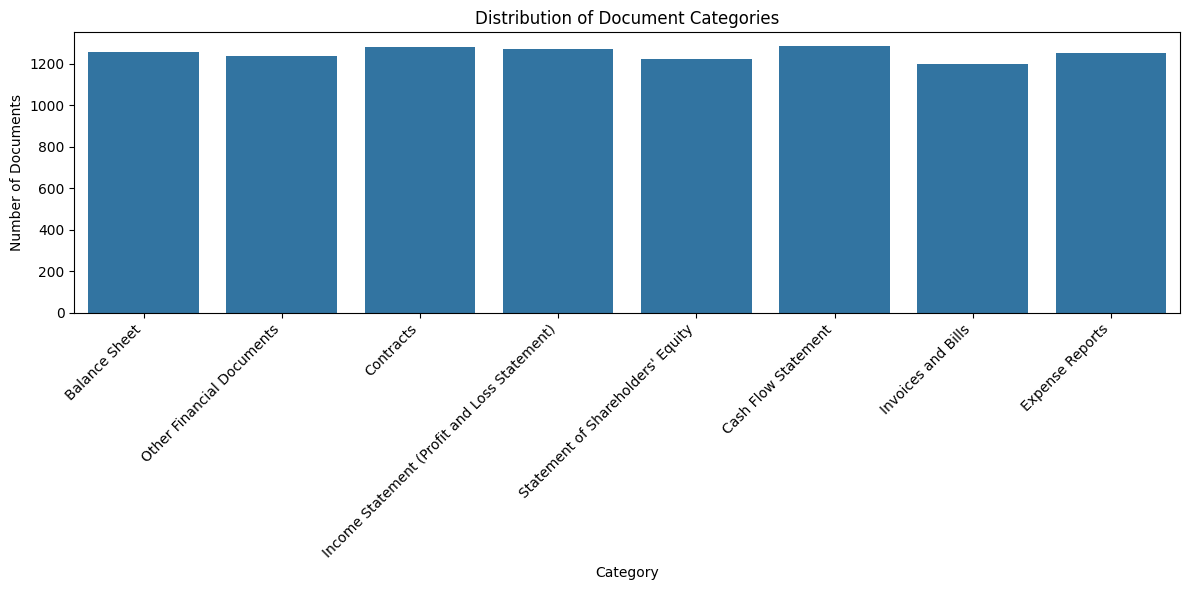

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Category Distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Document Categories')
plt.xlabel('Category')
plt.ylabel('Number of Documents')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
from wordcloud import WordCloud

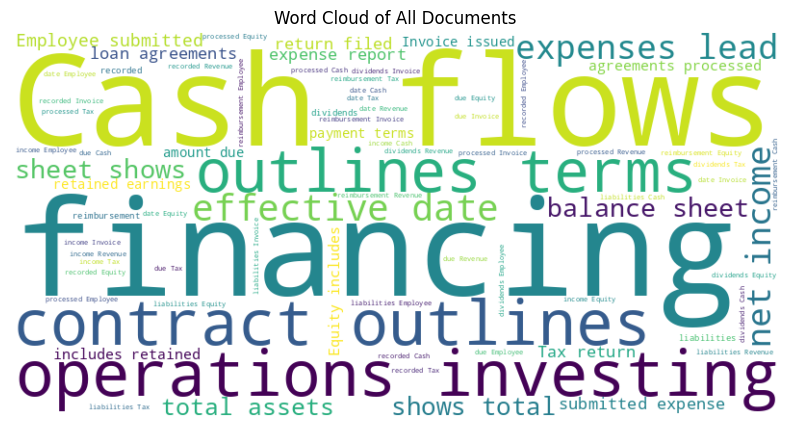

In [ ]:
text = " ".join(df['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Documents')
plt.show()

# **Preprocessing**

In [ ]:
# Encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Preprocessing
ps = PorterStemmer()
stop_words = stopwords.words('english')

def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text).lower().split()
    text = [ps.stem(word) for word in text if word not in set(stop_words)]
    return ' '.join(text)

df['clean_text'] = df['text'].apply(preprocess)

# **Train-Test Split**

In [ ]:
# Train-Test Split
X = df['clean_text']
y = df['label_encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **CNN model development**

In [ ]:
# CNN Preparation
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=50)
X_test_pad = pad_sequences(X_test_seq, maxlen=50)

# **Model architecture**

In [ ]:
# CNN Model
cnn_model = Sequential([
    Embedding(5000, 128, input_length=50),
    Conv1D(128, 5, activation='relu'),
    MaxPooling1D(5),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])
# Note the change in metrics here to include 'accuracy'
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('cnn_best_model.h5', save_best_only=True, monitor='val_loss')
]

# **CNN Model training**

In [ ]:
history = cnn_model.fit(
    X_train_pad, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test_pad, y_test),
    callbacks=cnn_callbacks
)

cnn_model.save('cnn_model.h5')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


241/250 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8076 - loss: 0.6946

250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8132 - loss: 0.6756 - val_accuracy: 1.0000 - val_loss: 3.2203e-04
Epoch 2/10
242/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.4713e-04

250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 1.0000 - loss: 2.4515e-04 - val_accuracy: 1.0000 - val_loss: 1.1219e-04
Epoch 3/10
237/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.3943e-05

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 9.3116e-05 - val_accuracy: 1.0000 - val_loss: 5.4822e-05
Epoch 4/10
239/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 4.7911e-05

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 4.7627e-05 - val_accuracy: 1.0000 - val_loss: 3.1880e-05
Epoch 5/10
238/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 2.8531e-05

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 2.8382e-05 - val_accuracy: 1.0000 - val_loss: 2.0509e-05
Epoch 6/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.8726e-05

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 1.0000 - loss: 1.8712e-05 - val_accuracy: 1.0000 - val_loss: 1.4199e-05
Epoch 7/10
237/250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 1.3195e-05

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.3135e-05 - val_accuracy: 1.0000 - val_loss: 1.0309e-05
Epoch 8/10
240/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 9.5549e-06

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 9.5274e-06 - val_accuracy: 1.0000 - val_loss: 7.7374e-06
Epoch 9/10
243/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 7.2523e-06

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 7.2371e-06 - val_accuracy: 1.0000 - val_loss: 5.9710e-06
Epoch 10/10
245/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 5.5840e-06

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 5.5767e-06 - val_accuracy: 1.0000 - val_loss: 4.7140e-06


# **Model accuracy and loss graph**

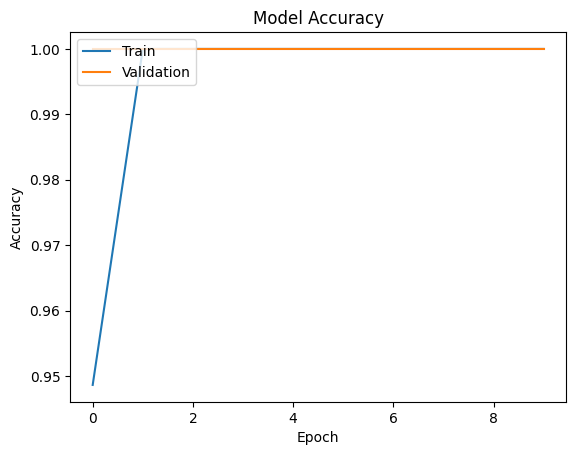

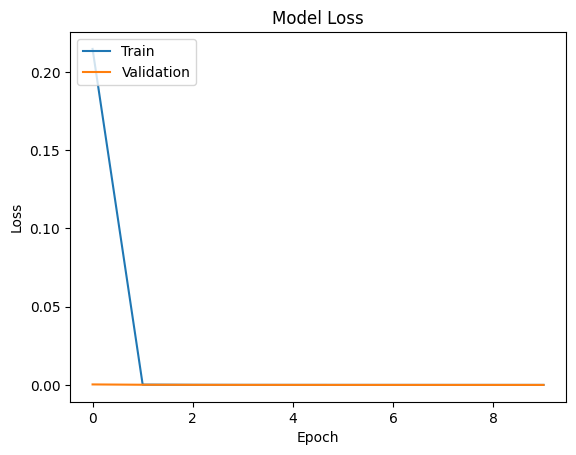

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **CNN model evaluation**

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


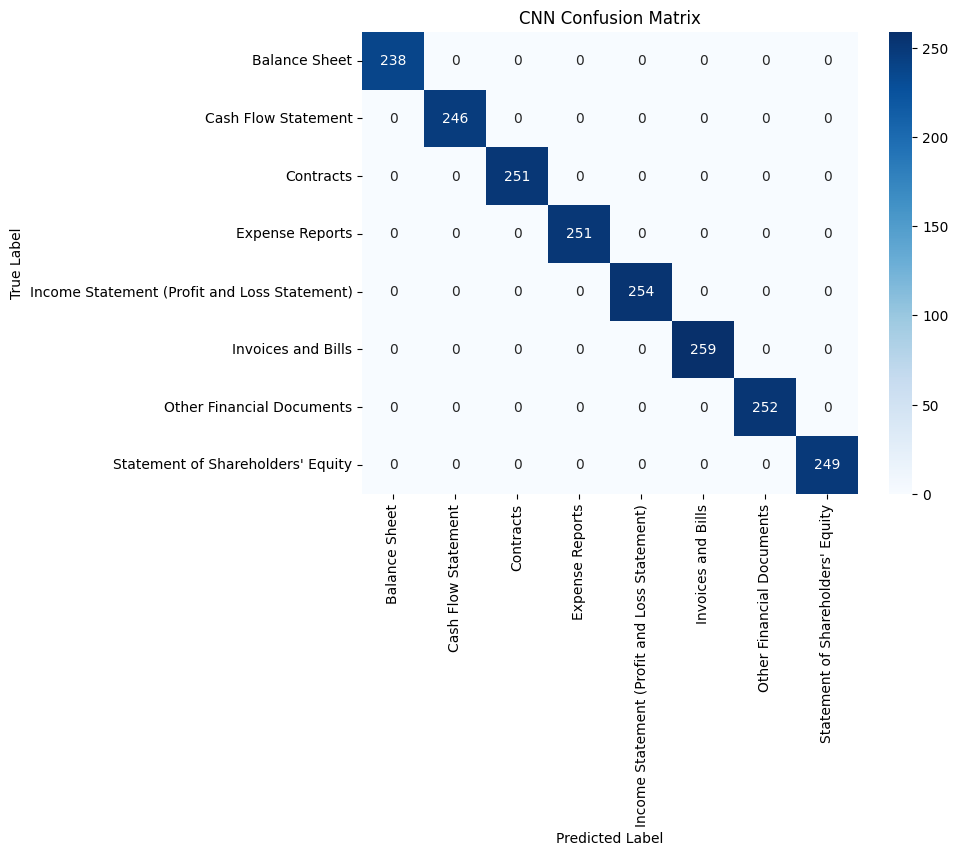

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# After training CNN model
cnn_predictions = cnn_model.predict(X_test_pad)
cnn_predicted_labels = cnn_predictions.argmax(axis=1)

# Visualize CNN performance
cnn_cm = confusion_matrix(y_test, cnn_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('CNN Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_test, cnn_predicted_labels, target_names=le.classes_))

                                              precision    recall  f1-score   support

                               Balance Sheet       1.00      1.00      1.00       238
                         Cash Flow Statement       1.00      1.00      1.00       246
                                   Contracts       1.00      1.00      1.00       251
                             Expense Reports       1.00      1.00      1.00       251
Income Statement (Profit and Loss Statement)       1.00      1.00      1.00       254
                          Invoices and Bills       1.00      1.00      1.00       259
                   Other Financial Documents       1.00      1.00      1.00       252
           Statement of Shareholders' Equity       1.00      1.00      1.00       249

                                    accuracy                           1.00      2000
                                   macro avg       1.00      1.00      1.00      2000
                                weighted avg       1

# **Developing BERT model**

In [ ]:
# BERT Classification
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

X_raw = df['text']
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_raw, y, test_size=0.2, random_state=42)

def tokenize_bert(data):
    return bert_tokenizer(
        text=list(data),
        add_special_tokens=True,
        max_length=100,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True
    )

X_train_tok = tokenize_bert(X_train_bert)
X_test_tok = tokenize_bert(X_test_bert)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
# Build BERT Classifier
input_ids = Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(100,), dtype=tf.int32, name="attention_mask")

# Create a custom layer to wrap the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Now you can directly use input_ids and attention_mask here
        return self.bert_model(input_ids, attention_mask=attention_mask)[1]

# Instantiate the custom layer
bert_layer = BertLayer(bert_model)

# Call the custom layer using the Functional API
pooled_output = bert_layer([input_ids, attention_mask])
x = Dropout(0.5)(pooled_output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(le.classes_), activation='softmax')(x)

bert_classifier = Model(inputs=[input_ids, attention_mask], outputs=output)
bert_classifier.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bert_classifier.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer          │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ bert_layer[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │     49,216 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │        520 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,736 (194.28 KB)

 Trainable params: 49,736 (194.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Build BERT Classifier
input_ids = Input(shape=(100,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(100,), dtype=tf.int32, name="attention_mask")

# Create a custom layer to wrap the BERT model
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, bert_model, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert_model = bert_model

    def call(self, inputs):
        input_ids, attention_mask = inputs
        # Now you can directly use input_ids and attention_mask here
        return self.bert_model(input_ids, attention_mask=attention_mask)[1]

    # Add get_config method to make the layer serializable
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'bert_model': self.bert_model.name, # Store the name of the BERT model
        })
        return config

    # Add from_config class method to load the layer from config
    @classmethod
    def from_config(cls, config):
        bert_model = TFBertModel.from_pretrained(config['bert_model']) # Load BERT model from name
        return cls(bert_model)

# Instantiate the custom layer
bert_layer = BertLayer(bert_model)

# Call the custom layer using the Functional API
pooled_output = bert_layer([input_ids, attention_mask])
x = Dropout(0.5)(pooled_output)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(le.classes_), activation='softmax')(x)

bert_classifier = Model(inputs=[input_ids, attention_mask], outputs=output)
bert_classifier.compile(optimizer=Adam(learning_rate=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
bert_classifier.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_1        │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 768)       │          0 │ bert_layer_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │     49,216 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 8)         │        520 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 49,736 (194.28 KB)

 Trainable params: 49,736 (194.28 KB)

 Non-trainable params: 0 (0.00 B)

# **Training BERT model**

In [ ]:
bert_callbacks = [
    EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True),
    ModelCheckpoint('bert_best_model.keras', save_best_only=True, monitor='val_loss')
]

history = bert_classifier.fit(
    x={"input_ids": X_train_tok['input_ids'], "attention_mask": X_train_tok['attention_mask']},
    y=y_train_bert,
    validation_data=({"input_ids": X_test_tok['input_ids'], "attention_mask": X_test_tok['attention_mask']}, y_test_bert),
    epochs=5,
    batch_size=16,
    callbacks=bert_callbacks
)

bert_classifier.save('bert_model.keras')
bert_tokenizer.save_pretrained('bert_tokenizer')

print("BERT Model Training Complete")

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 67s 110ms/step - accuracy: 0.1250 - loss: 2.8697 - val_accuracy: 0.1230 - val_loss: 2.0086
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 75s 104ms/step - accuracy: 0.1626 - loss: 2.1993 - val_accuracy: 0.2490 - val_loss: 2.0353
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 105ms/step - accuracy: 0.1711 - loss: 2.0942 - val_accuracy: 0.3745 - val_loss: 2.0310
BERT Model Training Complete


# **BERT model accuracy and loss graph**

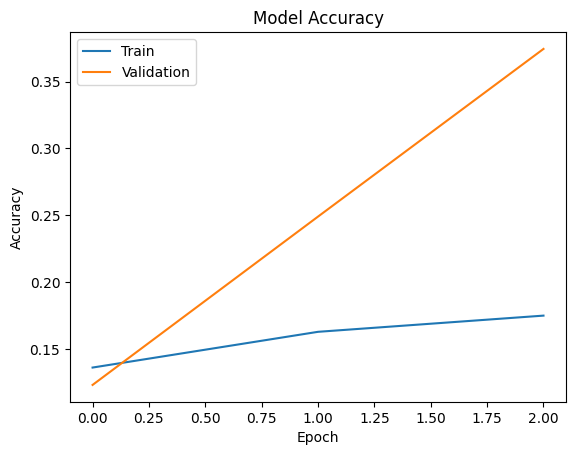

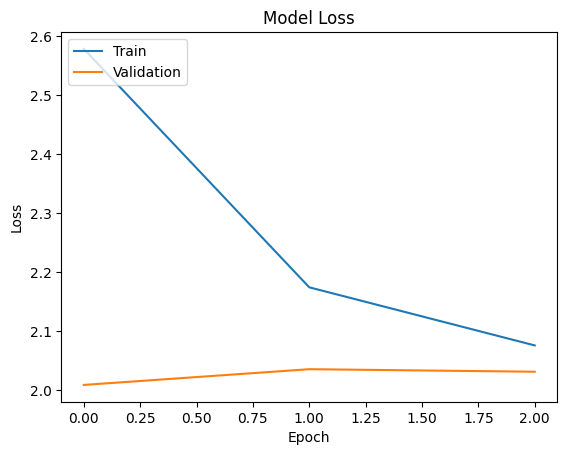

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **Evaluating BERT model**

63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 289ms/step


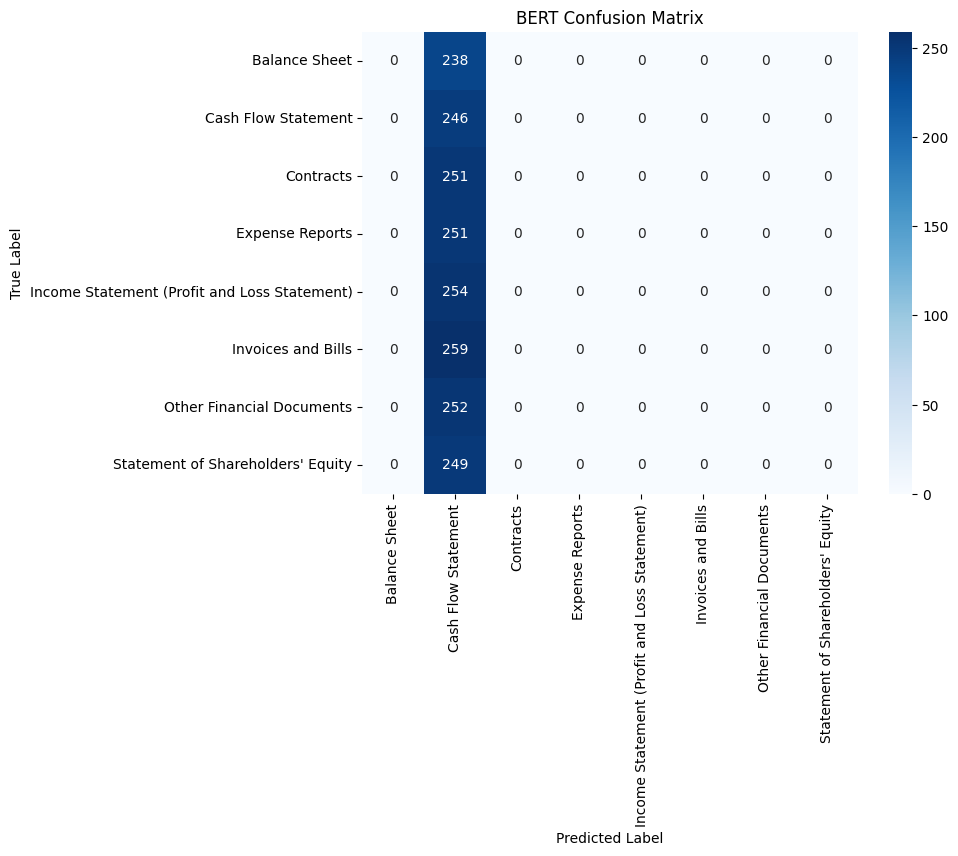

In [ ]:
# After training BERT model
bert_predictions = bert_classifier.predict({"input_ids": X_test_tok['input_ids'], "attention_mask": X_test_tok['attention_mask']})
bert_predicted_labels = bert_predictions.argmax(axis=1)

# Visualize BERT performance
bert_cm = confusion_matrix(y_test_bert, bert_predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(bert_cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('BERT Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(classification_report(y_test_bert, bert_predicted_labels, target_names=le.classes_))

                                              precision    recall  f1-score   support

                               Balance Sheet       0.00      0.00      0.00       238
                         Cash Flow Statement       0.12      1.00      0.22       246
                                   Contracts       0.00      0.00      0.00       251
                             Expense Reports       0.00      0.00      0.00       251
Income Statement (Profit and Loss Statement)       0.00      0.00      0.00       254
                          Invoices and Bills       0.00      0.00      0.00       259
                   Other Financial Documents       0.00      0.00      0.00       252
           Statement of Shareholders' Equity       0.00      0.00      0.00       249

                                    accuracy                           0.12      2000
                                   macro avg       0.02      0.12      0.03      2000
                                weighted avg       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
